# Assignment 2  
## Functional Link Artificial Neural Network 
### Data: Visa Inc. (V) Stock Prices, Dividends and Splits
##### By Srivatsa Sinha (BE/10327/2014)

In [1]:
## All libraries needed for the problem
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib as mpl
import matplotlib.pyplot  as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime
import math

### Dataset description
#### The dataset contains the daily stock price of Visa Inc. Source : Quandl
#### It contains following parameters 
<ol>
<li> Date: The Date on which the data has been recorded </li>
<li> Open: The opening price of the Visa Inc stock on that date </li>
<li> High: The highest price of the Visa Inc stock on that date </li>
<li> Low:  The Lowest price of the Visa Inc stock on that date </li>
<li> Close: The Closing price of the Visa Inc stock on that data </li>
<ol>

In [4]:
mpl.rcParams['lines.linewidth'] = 1
## Load data as pandas data frame
dataset = pd.read_csv('/home/srivatsa/Desktop/Neural-Network-And-Fuzzy-Systems-Assignment/dataset/EOD-V.csv')
## Essential Preprocessing
dataset = dataset.drop(['Volume','Dividend','Split','Adj_Open','Adj_Low','Adj_High','Adj_Close','Adj_Volume'],axis=1)
dataset = dataset.iloc[::-1]
dataset.tail()

,Date,Open,High,Low,Close
4,2017-08-31,104.06,104.190,103.025,103.52
3,2017-09-01,104.04,104.080,103.440,103.90
2,2017-09-05,103.40,103.460,102.260,103.01
1,2017-09-06,103.34,103.745,103.100,103.18
0,2017-09-07,103.71,105.440,103.610,104.56


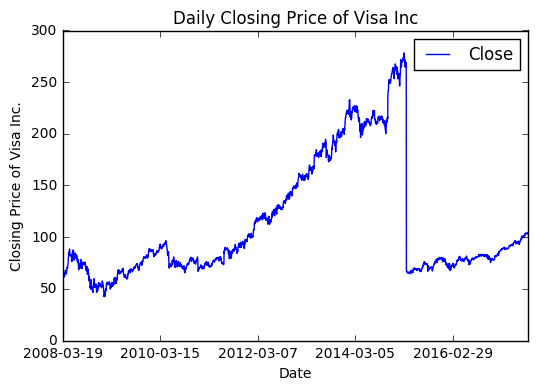

In [17]:
## Dataset Visualization
dataset.plot(x='Date',y='Close',title='Daily Closing Price of Visa Inc')
plt.xlabel('Date')
plt.ylabel('Closing Price of Visa Inc.')

### Model Description
#### In the following data I have used Functional Link Neural Network as the algorithm for creating a model for predicting daily closing stock prices of Visa Inc.
#### The hyperparametes for the model are:
<ol>
<li> Window Size : The number of previous points considered for predicted next point </li>
<li> Batch Size: The batch size for stocastic gradient descent algorithm </li>
<li> Learning Rate(lr): The learning rate for gradient descent algorithm </li>
<li> No of Epoch: The number epoch for traing the mode </li>
#### Trignometric functional expansion has been used as $f(x) = {x , sin(\pi x), cos(\pi x), sin(\pi x), cos(2\pi x) }$
#### Learning Rate is adaptive, i.e if the error increses in next iteration the learning rate is decresed by a factor of 10

Total data size 2384
Training data size 1788 and testing data size 596


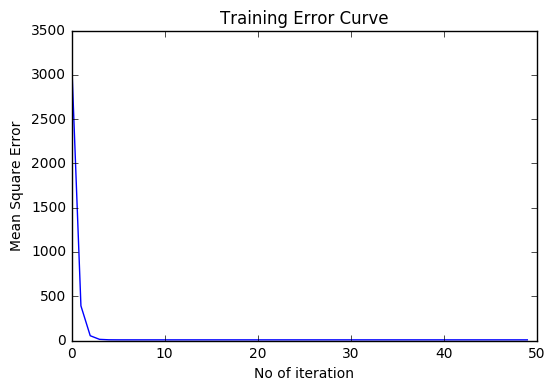

The least error achieved on training data: 7.21092288583


In [11]:
### Written by Srivatsa Sinha on 8th September, 2017

## Aplying FLANN Model

# Model Hyperparameters

window_size = 2
batch_size = 1660
input_dimension = window_size*5
lr = 1e-5
no_of_epoch = 50

# Model Training Parameters

W = np.random.normal(size=(input_dimension,1))
b = np.zeros((1,))

# Computational Procedures of FLANN

def train_test_split(X,y,train_size):
    X_train = X[0:int(train_size*len(X))]
    X_test  = X[int(train_size*len(X)):]
    y_train = y[0:int(train_size*len(y))]
    y_test  = y[int(train_size*len(y)):]
    return X_train, X_test, y_train, y_test


def functional_expansion(data_point):
    expanded_input = [data_point,math.sin(math.pi*data_point),math.cos(math.pi*data_point),math.sin(2*math.pi*data_point),math.cos(2*math.pi*data_point)]
    return expanded_input

def generate_input_data(closing_data):
    input_data = []
    target_data = []
    for idx in range(len(closing_data)-window_size):
        current_input = []
        for count in range(window_size):
            current_input += functional_expansion(closing_data[idx+count])
        input_data.append(current_input)
        target_data.append(closing_data[idx+window_size])
    input_data = np.array(input_data)
    target_data = np.array(target_data)
    return input_data, target_data
        

def compute_forward_pass(x,w,b):
    output = x.dot(w) + b
    cache = (x,w,b)
    return output,cache

def compute_error(output,expected_output):
    expected_output = expected_output.reshape(output.shape)
    error =  np.sum(np.square((expected_output-output)))/batch_size
    dy = -2*(expected_output-output)/batch_size
    return error,dy
    
    
def compute_backward_pass(dout,cache):
    x,w,b = cache
    dw,db = None,None
    dw = np.transpose(x).dot(dout)
    db = np.sum(dout,axis=0)
    return dw,db
    
    
def update_weight(dw,lr,w):
    w -= lr*dw
    return w

def update_bias(db,lr,b):
    b -= lr*db
    return b

#Data Process and Split
closing_data = np.array(dataset['Close'])
input_closing_data, target_closing_data = generate_input_data(closing_data)
length_of_data = len(input_closing_data) 

print "Total data size %s"%(length_of_data)
input_train, input_test, target_train, target_test = train_test_split(input_closing_data,target_closing_data,0.75)
print "Training data size %s and testing data size %s"%(len(target_train),len(target_test))

length_of_training_data = len(target_train)
errors = []

W_best = []
b_best = []
error_best = sys.float_info.max


## Training the model
for epoch in range(no_of_epoch):
    for i in range(length_of_training_data/batch_size):
        output,cache = compute_forward_pass(input_train[i*batch_size:(i+1)*batch_size],W,b)
        error,dy = compute_error(output,target_train[i*batch_size:(i+1)*batch_size])
        if(error<error_best):
            W_best = W
            b_best = b
            error_best = error
        if(len(errors)>0 and error>errors[-1]):
            lr/=10;
        dw,db = compute_backward_pass(dy,cache)
        W = update_weight(dw,lr,W)
        b = update_bias(db,lr,b)
        errors.append(error)
    

## Visualization of training error(MSE)
plt.plot(errors)
plt.xlabel("No of iteration")
plt.ylabel("Mean Square Error")
plt.title("Training Error Curve")
plt.show()
print "The least error achieved on training data: %s"%(error_best)


In [12]:
## Testing the model 
# Output on Test Data
output_test = compute_forward_pass(input_test,W_best,b_best)
error_test  = compute_error(output_test[0],target_test)
print "The error acheived in test data: %s"%(error_test[0])
# Output on Train Data
output_train =  compute_forward_pass(input_train,W_best,b_best)
error_train = compute_error(output_train[0],target_train)

The error acheived in test data: 0.976537603056


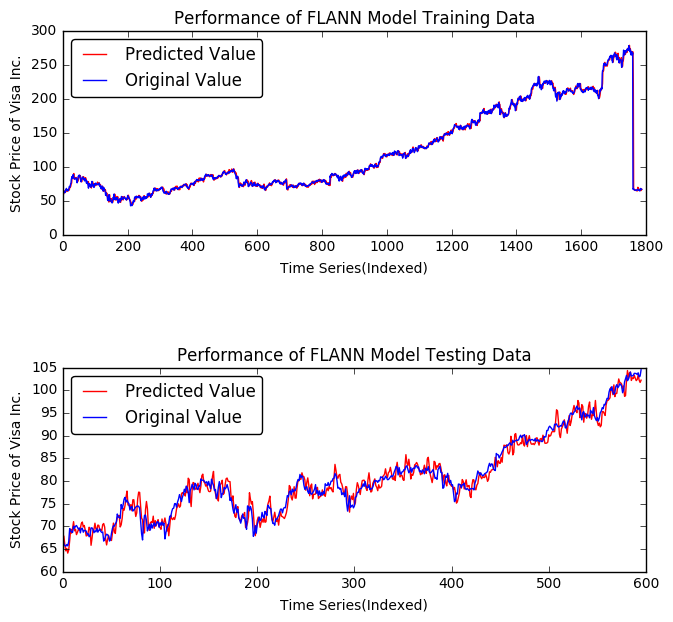

In [18]:
## Visualizing the model performance
# Visualizing the train data performance
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(output_train[0],'r', label="Predicted Value")
ax1.plot(target_train,'b', label="Original Value")
ax1.legend(loc="upper left",fancybox=True)
ax1.set_xlabel('Time Series(Indexed)')
ax1.set_ylabel('Stock Price of Visa Inc.')
ax1.set_title('Performance of FLANN Model Training Data')

# Visualizong the test data performace
ax2 = fig.add_subplot(212)
ax2.plot(output_test[0],'r', label="Predicted Value")
ax2.plot(target_test,'b', label="Original Value")
ax2.legend(loc="upper left",fancybox=True)
ax2.set_xlabel('Time Series(Indexed)')
ax2.set_ylabel('Stock Price of Visa Inc.')
ax2.set_title('Performance of FLANN Model Testing Data')
plt.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(7)
plt.show()

### Conclusions
<ol>
<li> The best train error(MSE) was 7.21 while test error was 0.97 indicating that our model showed good generalization in predicting the stock price.</li>
<li> Any learning rate greater than 1e-5 caused the error to shoot, probably our error surface was highly steep, and any attempt to descent, would rather cause it to shoot, therefore adaptive strategy was used to reduce the learning rate progressively and move towards optimal solution </li>
<li> On conducting various experiments with varying no of epoch, best result was achieved was 50, higher would cause overfitting and lesser would cause high train error </li>
<li> On conducting various experiment with varying window size, i concluded that lesser the window size better the performance. This can be due to the fact that higher window price takes into account various past prices which may not be relevent. The closing point of few days before data price are enough for people to bid for next price in case of Exchange Traded Fund. Day traders generally takes into account 1-2 day data and put their bid. </li>
<li> The Model performed well on all other data also, i.e opening price(MSE 1.24), highest price(MSE 1.84) and lowest price(MSE 1.58)</li>
<ol>